# **SETUP**

## **Libraries**

In [6]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.13.0
Hub version: 0.14.0
GPU is available


## **Mounting google drive**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **Cloning and building the Darknet**

In [3]:
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15750, done.
remote: Counting objects: 100% (213/213), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 15750 (delta 103), reused 155 (delta 85), pack-reused 15537
Receiving objects: 100% (15750/15750), 14.66 MiB | 11.58 MiB/s, done.
Resolving deltas: 100% (10532/10532), done.


In [4]:
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

/content/darknet


In [5]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [7]:
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wunused-but-set-variable-Wunused-but-set-variable]8;;]
  946 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void cv_draw_object(image, float*, int, int, int*, float*, int*, int, char**)’:
./src/image_opencv.cpp:1444:14: warning: unused var

## **Download pretrained yolo v3 weights**

In [8]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2023-09-16 22:50:17--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  16.7MB/s    in 15s     

2023-09-16 22:50:33 (15.6 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [9]:
import cv2
import matplotlib.pyplot as plt
def show_image(path):

  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

def upload():
  from google.colab import files
  uploaded = files.upload()
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

def download(path):
  from google.colab import files
  files.download(path)

# **Training a Custom YOLOv3 Object Detector**

## **Moving Custom Dataset Into Cloud**


In [10]:
!ls /content/gdrive/MyDrive/Politechnika/Magisterka/dataset/CNN/YOLOv3

backup		   generate_val.py  obj.names
generate_train.py  obj.data	    yolov3-custom.cfg


In [11]:
!cp /content/gdrive/MyDrive/Politechnika/Magisterka/dataset/CNN/YOLOv3/train.zip ../

In [12]:
!unzip ../train.zip -d data/obj

Archive:  ../train.zip
  inflating: data/obj/0000.jpg       
  inflating: data/obj/0000.txt       
  inflating: data/obj/0001.jpg       
  inflating: data/obj/0001.txt       
  inflating: data/obj/0002.jpg       
  inflating: data/obj/0002.txt       
  inflating: data/obj/0003.jpg       
  inflating: data/obj/0003.txt       
  inflating: data/obj/0006.jpg       
  inflating: data/obj/0006.txt       
  inflating: data/obj/0007.jpg       
  inflating: data/obj/0007.txt       
  inflating: data/obj/0008.jpg       
  inflating: data/obj/0008.txt       
  inflating: data/obj/0009.jpg       
  inflating: data/obj/0009.txt       
  inflating: data/obj/0010.jpg       
  inflating: data/obj/0010.txt       
  inflating: data/obj/0011.jpg       
  inflating: data/obj/0011.txt       
  inflating: data/obj/0012.jpg       
  inflating: data/obj/0012.txt       
  inflating: data/obj/0013.jpg       
  inflating: data/obj/0013.txt       
  inflating: data/obj/0014.jpg       
  inflating: data/obj/0014.

## **Configuring Files for Training**

I) cfg file

In [13]:
!cp /content/gdrive/MyDrive/Politechnika/Magisterka/dataset/CNN/YOLOv3/yolov3-custom.cfg ./cfg

II) obj.names and obj.data

In [14]:
!cp /content/gdrive/MyDrive/Politechnika/Magisterka/dataset/CNN/YOLOv3/obj.names ./data
!cp /content/gdrive/MyDrive/Politechnika/Magisterka/dataset/CNN/YOLOv3/obj.data  ./data

III) train.txt

In [32]:
!cp /content/gdrive/MyDrive/Politechnika/Magisterka/dataset/CNN/YOLOv3/generate_train.py ./
!cp /content/gdrive/MyDrive/Politechnika/Magisterka/dataset/CNN/YOLOv3/generate_val.py ./
!cp /content/gdrive/MyDrive/Politechnika/Magisterka/dataset/CNN/YOLOv3/generate_test.py ./

In [16]:
!python generate_train.py

In [17]:
!python generate_val.py

## **Download pre-trained weights for the convolutional layers.**

In [18]:
# upload pretrained convolutional layer weights
!wget http://pjreddie.com/media/files/darknet53.conv.74

URL transformed to HTTPS due to an HSTS policy
--2023-09-16 22:51:10--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  16.9MB/s    in 10s     

2023-09-16 22:51:21 (15.1 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



## **Training**

In [20]:
!./darknet detector train data/obj.data cfg/yolov3-custom.cfg darknet53.conv.74 backup/810.weights -map -dont_show

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
 total_bbox = 2150149, rewritten_bbox = 0.013627 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.000000), count: 1, class_loss = 0.000000, iou_loss = 0.000000, total_loss = 0.000000 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.000000), count: 1, class_loss = 0.000000, iou_loss = 0.000000, total_loss = 0.000000 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.846723), count: 2, class_loss = 0.000000, iou_loss = 0.053692, total_loss = 0.053692 
 total_bbox = 2150151, rewritten_bbox = 0.013627 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.000000), count: 1, class_loss = 0.000000, iou_loss = 0.000000, total_loss = 0.000000 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.885417), count: 1, class_loss = 0.000008, iou_loss = 0.012461, total_loss = 

## **Continue to train after problems with Colab**

In [ ]:
!ls /content/gdrive/MyDrive/Politechnika/Magisterka/dataset/CNN/YOLOv3/backup/

In [ ]:
!./darknet detector train data/obj.data cfg/yolov3-custom.cfg /content/gdrive/MyDrive/Politechnika/Magisterka/dataset/CNN/YOLOv3/backup/yolov3_custom_last.weights -dont_show

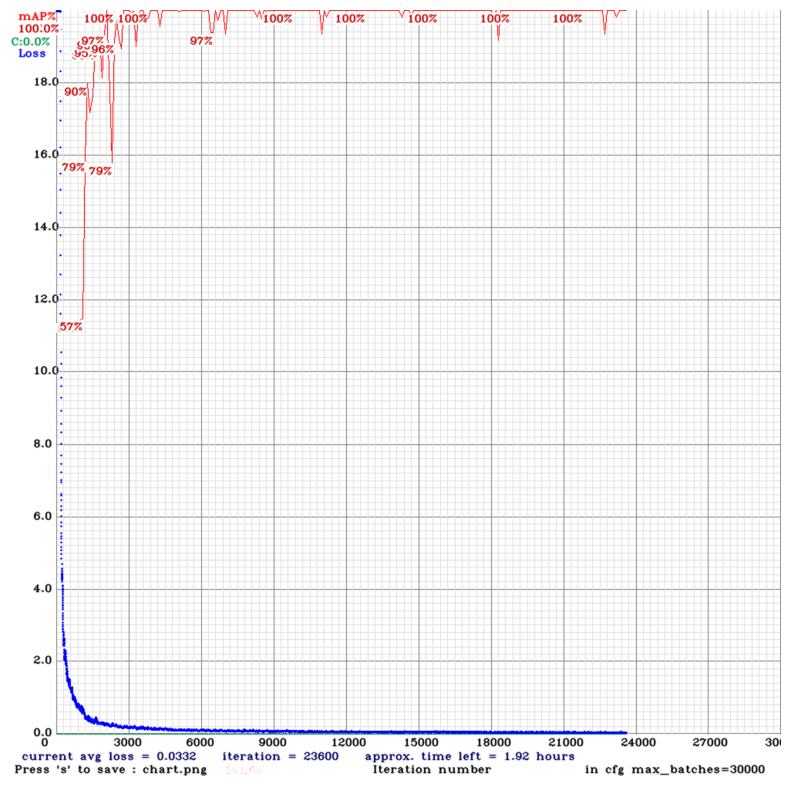

In [21]:
show_image("chart.png")

# **Testing a Custom YOLOv3 Object Detector on single image**


In [23]:

%cd cfg
!sed -i 's/batch=64/batch=1/' yolov3-custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov3-custom.cfg
%cd ..

/content/darknet/cfg
/content/darknet


 CUDA-version: 11080 (12000), cuDNN: 8.9.0, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.5.4
 0 : compute_capability = 800, cudnn_half = 1, GPU: NVIDIA A100-SXM4-40GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 32, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 1

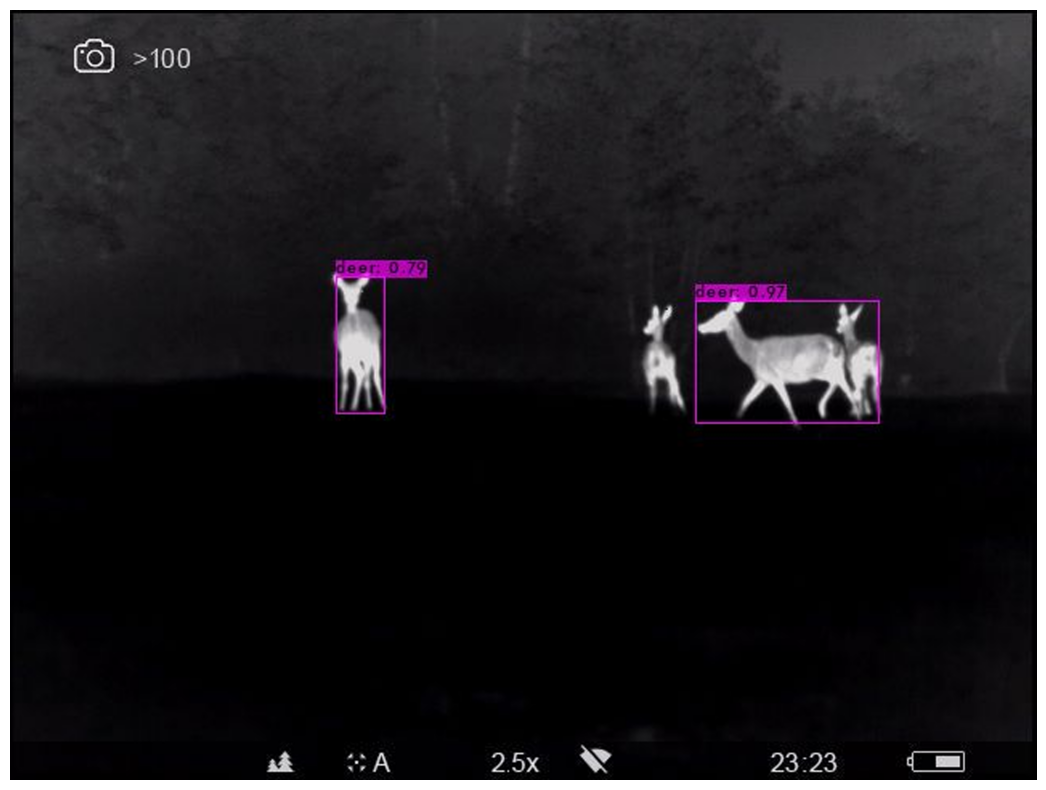

In [27]:
!./darknet detector test data/obj.data cfg/yolov3-custom.cfg /content/darknet/backup/yolov3-custom_10000.weights /content/gdrive/MyDrive/Politechnika/Magisterka/dataset/CNN/YOLOv3/example/img_579.jpg -thresh 0.2
show_image('predictions.jpg')

# **Calculating mAP (AP50)**


Cleaning data/obj directory

In [22]:
!rm data/obj/*

In [29]:
!cp /content/gdrive/MyDrive/Politechnika/Magisterka/dataset/CNN/YOLOv3/test.zip ../

In [30]:
!unzip ../test.zip -d data/obj

Archive:  ../test.zip
  inflating: data/obj/0004.jpg       
  inflating: data/obj/0004.txt       
  inflating: data/obj/0005.jpg       
  inflating: data/obj/0005.txt       
  inflating: data/obj/0027.jpg       
  inflating: data/obj/0027.txt       
  inflating: data/obj/0028.jpg       
  inflating: data/obj/0028.txt       
  inflating: data/obj/0030.jpg       
  inflating: data/obj/0030.txt       
  inflating: data/obj/0043.jpg       
  inflating: data/obj/0043.txt       
  inflating: data/obj/0048.jpg       
  inflating: data/obj/0048.txt       
  inflating: data/obj/0050.jpg       
  inflating: data/obj/0050.txt       
  inflating: data/obj/0054.jpg       
  inflating: data/obj/0054.txt       
  inflating: data/obj/0066.jpg       
  inflating: data/obj/0066.txt       
  inflating: data/obj/0068.jpg       
  inflating: data/obj/0068.txt       
  inflating: data/obj/0082.jpg       
  inflating: data/obj/0082.txt       
  inflating: data/obj/0083.jpg       
  inflating: data/obj/0083.t

In [34]:
!python generate_test.py

In [35]:
%cd data
!sed -i 's/val.txt/test.txt/' obj.data
%cd ..

/content/darknet/data
/content/darknet


In [36]:
!./darknet detector map data/obj.data cfg/yolov3-custom.cfg /content/gdrive/MyDrive/Politechnika/Magisterka/dataset/CNN/YOLOv3/backup/yolov3-custom_10000.weights

 CUDA-version: 11080 (12000), cuDNN: 8.9.0, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.5.4
 0 : compute_capability = 800, cudnn_half = 1, GPU: NVIDIA A100-SXM4-40GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 32, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 1